In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [2]:

import numpy as np

# 讀取並預處理圖片 (使用 PIL)
def load_image_pil(image_path, target_shape, num_channels):
    image = Image.open(image_path)  # 讀取圖片
    image = image.resize(target_shape)  # 調整大小

    if num_channels == 1:  # 對於mask圖像
        image = image.convert("L")  # 轉成灰度圖
        image = np.expand_dims(np.array(image), axis=-1)  # 增加channel維度
        image = np.expand_dims(image, axis=0)  # 增加batch維度
        image = (image / 255.)
    else:
        image = image.convert("RGB")  # 確保是RGB格式
        image = np.array(image)  # 轉換為numpy array
        image = np.expand_dims(image, axis=0)  # 增加batch維度
        image = (image / 255.) # 正規化到[-1, 1]之間

    return image.astype(np.float32)  # 保證是float32類型

In [ ]:
import cv2


# 讀取並預處理圖片
def load_image(image_path, target_shape, num_channels):
    image = cv2.imread(image_path)  # 讀取圖片
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 轉換為RGB
    image = cv2.resize(image, target_shape)  # 調整大小
    image = np.expand_dims(image, axis=0)  # 增加batch維度

    if num_channels == 1:  # 對於mask圖像
        image = cv2.cvtColor(image[0], cv2.COLOR_RGB2GRAY)  # 轉成灰度圖
        image = np.expand_dims(image, axis=-1)  # 增加channel維度
        image = np.expand_dims(image, axis=0)  # 再增加batch維度
        image = (image/255.)
    else:
      image = (image/255 * 2) -1   # 正規化到[0,1]之間

    return image.astype(np.float32)  # 保證是float32類型

# Input [1, 3, 512, 512], [1, 1, 512, 512]

In [5]:
# 1. 載入 TFLite 模型
interpreter = tf.lite.Interpreter(model_path="/content/places_lama.tflite")
# interpreter = tf.lite.Interpreter(model_path="LaMa-Dilated.tflite")

interpreter.allocate_tensors()

# 2. 取得模型的輸入輸出資訊
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. 定義圖片路徑，並載入圖片
image_path = "test3.png"
# input_image = Image.open(image_path)
input_image = load_image_pil("/content/test3.png", (512, 512), 3)


mask_path = "test3_n.png"
# input_mask = Image.open(image_path).convert('L')
input_mask = load_image_pil("/content/mask3_n.png", (512, 512), 1)

print(f'input_image: {input_image.shape}')
print(f'input_mask: {input_mask.shape}')

# transpose
# input_image_t = tf.transpose(input_image, [0, 3, 1, 2])
# input_mask_t = tf.transpose(input_mask, [0, 3, 1, 2])

# print(f'input_image: {input_image_t.shape}')
# print(f'input_mask: {input_mask_t.shape}')

# 5. 將圖片數據設為模型的輸入
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.set_tensor(input_details[1]['index'], input_mask)

# 6. 執行推理
interpreter.invoke()

# 7. 取得輸出結果
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Model Output shape:", output_data[0].shape)

input_image: (1, 512, 512, 3)
input_mask: (1, 512, 512, 1)
Model Output shape: (512, 512, 3)


# Input = [1, 4, 512, 512]





In [7]:
# 1. 載入 TFLite 模型
interpreter = tf.lite.Interpreter(model_path="/content/places_lama.tflite")

interpreter.allocate_tensors()

# 2. 取得模型的輸入輸出資訊
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. 定義圖片路徑，並載入圖片
image_path = "test3.png"
# input_image = Image.open(image_path)
input_image = load_image_pil("/content/test3.png", (512, 512), 3)


mask_path = "test3_n.png"
# input_mask = Image.open(image_path).convert('L')
input_mask = load_image_pil("/content/mask3_n.png", (512, 512), 1)

print(f'input_image: {input_image.shape}')
print(f'input_mask: {input_mask.shape}')

# transpose
input_image_t = tf.transpose(input_image, [0, 3, 1, 2])
input_mask_t = tf.transpose(input_mask, [0, 3, 1, 2])

print(f'input_image: {input_image_t.shape}')
print(f'input_mask: {input_mask_t.shape}')

masked_img_t = input_image_t * (1 - input_mask_t)
# masked_img = tf.concat([masked_img, mask], axis=1)
masked_img_t = tf.concat([masked_img_t, input_mask_t], axis=1)
print(f'masked_img_t: {masked_img_t.shape}')


# 5. 將圖片數據設為模型的輸入
interpreter.set_tensor(input_details[0]['index'], masked_img_t)
# interpreter.set_tensor(input_details[1]['index'], input_mask_t)

# 6. 執行推理
interpreter.invoke()

# 7. 取得輸出結果
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Model Output shape:", output_data[0].shape)

input_image: (1, 512, 512, 3)
input_mask: (1, 512, 512, 1)
input_image: (1, 3, 512, 512)
input_mask: (1, 1, 512, 512)
masked_img_t: (1, 4, 512, 512)
Model Output shape: (3, 512, 512)


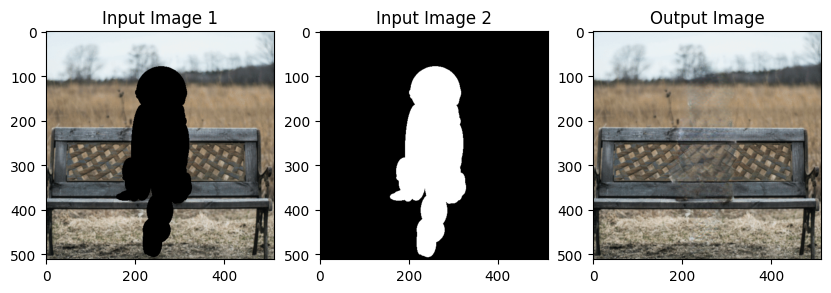

In [6]:
import matplotlib.pyplot as plt

# Assuming input_data_1, input_data_2, and output_data are already defined

# Display input image 1
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)

mmm = input_image * (1 - input_mask)

# plt.imshow(input_image[0])
plt.imshow(mmm[0])
plt.title("Input Image 1")

# Display input image 2
plt.subplot(1, 3, 2)
plt.imshow(input_mask[0, ..., 0], cmap='gray')  # Assuming it's a grayscale image
plt.title("Input Image 2")

# Display output image
plt.subplot(1, 3, 3)

# output_data = tf.transpose(output_data, [0, 2, 3, 1])


plt.imshow(output_data[0])
plt.title("Output Image")

plt.show()

(512, 512, 3)


Text(0.5, 1.0, 'Output Image')

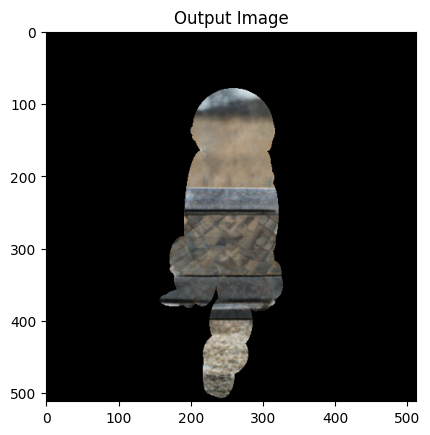

In [7]:
# output_data = output_data * input_mask


cropped_output = output_data
# cropped_output = output_data[:, 8:-8, 8:-8, : ]

# ccc = cropped_output * input_mask + mmm
ccc = cropped_output - mmm

print(cropped_output[0].shape)
plt.imshow(ccc[0])
plt.title("Output Image")

In [3]:
## pytorch


import torch
import torchvision.transforms as transforms
from PIL import Image

# 1. 載入 PyTorch 模型
model = torch.load("/content/places_lama-jit.pt")
model.eval()  # 設定為評估模式

# 3. 定義圖片路徑，並載入圖片
image_path = "test3.png"
# input_image = Image.open(image_path)
input_image = load_image_pil("/content/test3.png", (512, 512), 3)


mask_path = "test3_n.png"
# input_mask = Image.open(image_path).convert('L')
input_mask = load_image_pil("/content/mask3_n.png", (512, 512), 1)

print(f'input_image: {input_image.shape}')
print(f'input_mask: {input_mask.shape}')

# 3. 轉換 NumPy 陣列為 PyTorch 張量
input_image_tensor = torch.from_numpy(input_image).permute(0, 3, 1, 2)  # (1, 512, 512, 3) -> (1, 3, 512, 512)
input_mask_tensor = torch.from_numpy(input_mask).permute(0, 3, 1, 2)  # (1, 512, 512, 1) -> (1, 1, 512, 512)


# 4. 將圖片數據設為模型的輸入
with torch.no_grad():  # 在推理時不計算梯度
    output_data = model(input_image_tensor, input_mask_tensor)

# 5. 輸出結果
print("Model Output:", output_data.shape)

<ipython-input-3-19756877213f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/places_lama-jit.pt")
/usr/local/lib/python3.10/dist-packages/tor

input_image: (1, 512, 512, 3)
input_mask: (1, 512, 512, 1)
Model Output: torch.Size([1, 3, 512, 512])
